In [1]:
import sys
sys.path.insert(0, '../')
sys.path.append('/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages') # se non carica gymnasium mettere path modulo


import gymnasium as gym
print(f"Gym Version = {gym.__version__}")

import AddictiveReward

import numpy as np
import numba as nb
from numba.experimental import jitclass

from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
#from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from typing import Optional

Gym Version = 0.29.1


In [2]:
env = gym.make('AddictiveEnv_v3')

### Data Plot

In [3]:
def data_plot():
    binary_data = env.unwrapped.get_statistics() 
    time_values = np.arange(len(binary_data))
    
    
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.plot(healthy_rates, label='Total Reward')
    plt.title('Total Reward (testing)')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.legend()
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    
    # Plot for total_reward
    plt.subplot(2, 2, 2)
    plt.plot(total_reward, label='Total Reward')
    plt.title('Total Reward (testing)')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.legend()
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.subplot(2, 2, 4)
    plt.scatter(time_values, binary_data, marker='o', linestyle='-')
    plt.title('T Addicted Arm (Class)')
    plt.xlabel('Episode')
    plt.ylabel('Total addicted arm')
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

## AGENTE MF

In [4]:
class MFLearningAgent:
    def __init__(self, 
                 learning_rate: float,  
                 initial_epsilon: float, 
                 epsilon_decay: float,  
                 final_epsilon: float, 
                 discount_factor: float = 0.9):
        
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.training_error = []

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values
    
    # def update_value_iteration(self, state, action, reward, next_state):
    #     old_value = self.q_values[state, action] 
    #     next_max = np.max(self.value_iteration[next_state, :])
    #     self.q_values[state, action] =  (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max) 

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

        
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

### Test MF

In [5]:
lr = 0.01

n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

agentMF = MFLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)


In [8]:
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
addiction_states = []
total_reward = []
healty_states = []
healthy_rates = []

t_healty_arm = []
t_addicted_arm = []
pbar = tqdm(total = env.get_iter()+1)

obs, info = env.reset()
done = False
addicted = 0
healthy = 0
r = 0

healty_arm = 0
addicted_arm = 0

step = 1
# play one episode

a_count = 1
h_count = 1


while not done:
    action = agentMF.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

  
    # update the agent
    agentMF.update(obs, action, reward, terminated, next_obs)
    
    # update if the environment is done and the current obs    
    # if obs == 3 and next_obs == 2 and reward != 0:
    #     healty_arm += 1
    # if obs == 3 and next_obs == 4:
    #     addicted_arm += 1
        
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1
        
    done = terminated or truncated
    obs = next_obs
    r += reward
    
    addiction_states.append(addicted)
    total_reward.append(r)
    healty_states.append(healthy)
    t_healty_arm.append(healty_arm)
    t_addicted_arm.append(addicted_arm)

    
    healthy_rates.append(h_count / a_count)



    
    step += 1
    pbar.update(1)
pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 21564.38it/s]


In [10]:
agentMF.q_values[3]
print(a_count)
print(h_count)

6
311


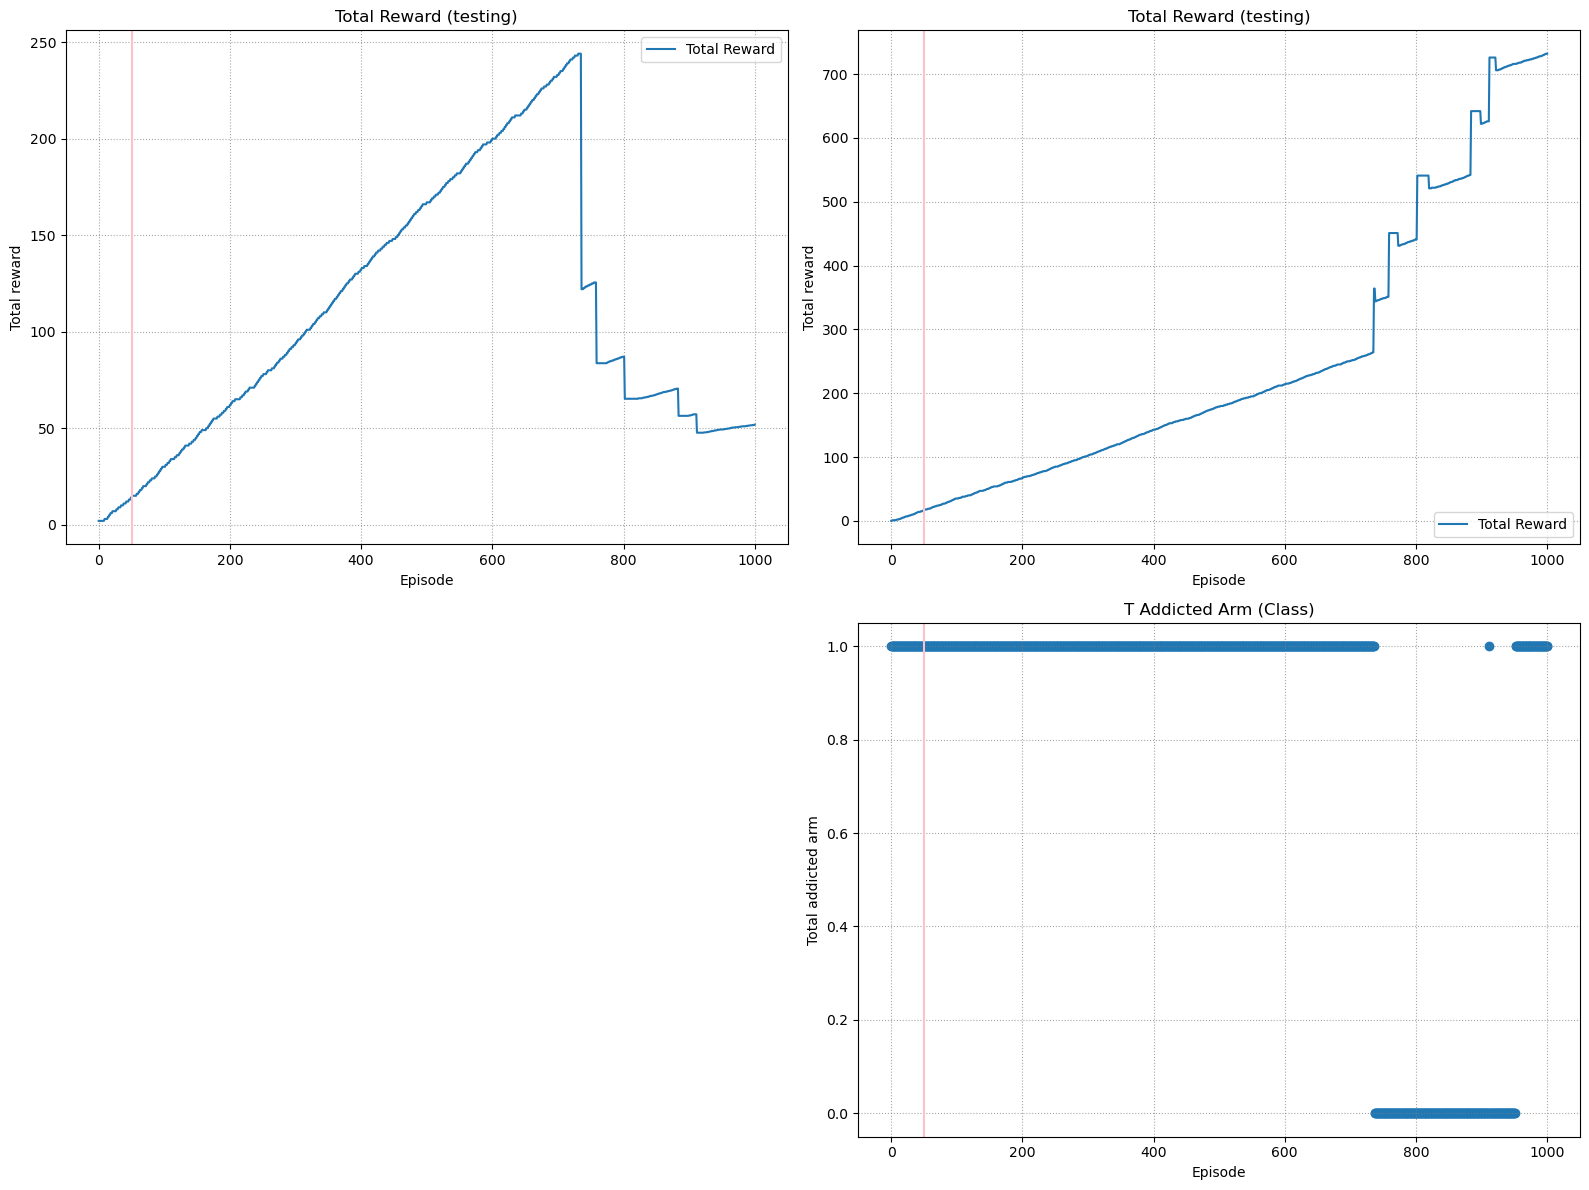

In [11]:
# print(addicted)
# print(healty)
data_plot()

## AGENTE MB

### Classes

In [5]:
import heapq
class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def is_empty(self):
        if self._queue  == []:
            return True
        return False
        
    def insert(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def clean(self):
        self._queue = []
        self.index = 0
        
    def pop(self):
        return heapq.heappop(self._queue)[-1]

#### GPU test ####

In [6]:
def transition_model_to_numpy(transition_model, obs_space, action_space):
    transition_array = np.zeros((obs_space, action_space, obs_space, 3))  # Assuming 3 fields: count, probability, reward
    
    for state in range(1, obs_space):
        for action in range(action_space):
            for next_state in range(1, obs_space):
                transition_info = transition_model[state][action].get(next_state, {'count': 0, 'probability': 0, 'reward': 0})
                transition_array[state, action, next_state] = [transition_info.get('count', 0), transition_info.get('probability', 0), transition_info.get('reward', 0)]

    #print(transition_array)
    return transition_array



@nb.jit
def value_iteration_gpu(iterations, obs_space, action_space, transition_model, discount_factor, q_values):
    epsilon = 0.1
    delta = 1.0  # Set an initial value for delta
    
    while iterations > 0 and delta > epsilon:
        delta = 0
        
        for state in range(1, obs_space):
            for action in range(action_space):
                t = 0
                for next_state in range(1, obs_space):
                    count, probability, reward = transition_model[state, action, next_state]
                    t += probability * (reward + discount_factor * np.max(q_values[next_state]))
                q_values[state, action] = t
            
                # Calculate delta
                Vs = abs(q_values[state, action] - np.max(q_values[state]))
                delta = max(delta, Vs)
        
        iterations -= 1  # Decrease the number of iterations
    
    return q_values

#### mb agent

In [7]:
class MBLearningAgent:
    def __init__(self, learning_rate: float, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.9, mbus = 50 ,theta=0.01):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.mbus = mbus
        self.transition_model = {} 
        self.initialize_transition_model()
        
        self.training_error = []
        
        self.pred_queue = PriorityQueue()
        self.theta = theta 
        self.upd = 0
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values

    def value_iteration(self, iter):
        epsilon = 0.1
        for _ in range(1, iter):
            delta = 0
            for state in range(1, env.observation_space.n):
                for action in range(0,  env.action_space.n):
                    t = 0
                    for next_state in self.transition_model[state][action]:
                        probability = self.transition_model[state][action][next_state]['probability']
                        reward = self.transition_model[state][action][next_state]['reward']
                        t += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
                    self.q_values[state][action] = t
                     
                Vs = abs(self.q_values[state][action] - np.max(self.q_values[state]))
                delta = max(delta, Vs)
                
            if delta < epsilon and delta > 0:
                break

    def prioritized_sweeping(self, state, action):
        self.calculate_sweep(state, action)
        while not (self.pred_queue.is_empty()):
            if self.upd > self.mbus:
                #print("stopped")
                self.pred_queue.clean()
                break
            state = self.pred_queue.pop()
                        
            for state_p in range(1, env.observation_space.n):
                for action_p in range(env.action_space.n): 
                    for next_state_p in self.transition_model[state_p][action_p]:
                        if next_state_p == state:
                            self.calculate_sweep(state_p, action_p)
                            

    def calculate_sweep(self, state, action):
        old_q = self.q_values[state][action]
        new_q = 0
        
        for next_state in self.transition_model[state][action]:
            probability = self.transition_model[state][action][next_state]['probability']
            reward = self.transition_model[state][action][next_state]['reward']
            new_q += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
        self.q_values[state][action] = new_q
        p = abs(new_q - old_q)
        if p > 0:
            self.upd += 1
            max_q = np.max(self.q_values[state])
            if old_q == max_q or new_q == max_q:
                 self.pred_queue.insert(state, p)
       
    def initialize_transition_model(self):
        for state in range(1, env.observation_space.n):
            self.transition_model[state] = {}
            for action in range(env.action_space.n):
                self.transition_model[state][action] = {}
                for next_state in range(env.observation_space.n):
                    self.transition_model[state][action][next_state] = {'count': 0, 'probability': 0, 'reward': 0}
                    
    def update_transition_model(self, state, action, next_state, reward):
        self.transition_model[state][action][next_state]['count'] += 1
        self.transition_model[state][action][next_state]['reward'] = reward
        self.calculate_transition_probabilities()
        
        #self.prioritized_sweeping(obs, action)
        
        transition_array = transition_model_to_numpy(self.transition_model, env.observation_space.n, env.action_space.n)
        self.q_values = value_iteration_gpu(self.mbus, env.observation_space.n, env.action_space.n, transition_array, self.discount_factor, self.q_values)
        
        #self.value_iteration(self.mbus)
        
    def calculate_transition_probabilities(self):
        
        for state in range(1, env.observation_space.n):
            for action in range(env.action_space.n):
                total_count = sum(self.transition_model[state][action][next_state]['count'] for next_state in self.transition_model[state][action])
                for next_state in self.transition_model[state][action]:
                    
                    c = self.transition_model[state][action][next_state]['count']
                    if total_count == 0:
                        total_count = 1
                    self.transition_model[state][action][next_state]['probability'] = c / total_count
                    #if  self.transition_model[state][action][next_state]['probability'] != 0:
                    #    print(f"{state} {action} {next_state} { self.transition_model[state][action][next_state]['probability']}")
    
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    

### Test MB

In [33]:
lr = 0.01
n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

agentMB = MBLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    mbus = 1
)

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(


In [35]:
addiction_states = []
total_reward = []
healty_states = []

t_healty_arm = []
t_addicted_arm = []
pbar = tqdm(total = env.get_iter() + 1)

obs, info = env.reset()

done = False
addicted = 0
healthy = 0
r = 0

healty_arm = 0
addicted_arm = 0

pippo = 0
healthy = 0

step = 1
# play one episode
while not done:
    action = agentMB.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    agentMB.update_transition_model(obs, action, next_obs, reward)
    
    # update if the environment is done and the current obs    
    if obs == 3 and next_obs == 2 and reward != 0:
        healty_arm += 1
    if obs == 3 and next_obs == 4:
        addicted_arm += 1
    # if next_obs == 4:
    #     addicted += 1 
    # if next_obs == 1:
    #     healty += 1
    
    if(action == 8):
       pippo = pippo + 1
    if(obs == 2 and next_obs == 1):
       healthy = healthy + 1
        
    done = terminated or truncated
    obs = next_obs
    r += reward

    agentMB.decay_epsilon()
    
    addiction_states.append(addicted)
    total_reward.append(r)
    healty_states.append(healty)
    t_healty_arm.append(healty_arm)
    t_addicted_arm.append(addicted_arm)
    
    step += 1
    pbar.update(1)

print(pippo)
print(healthy)
pbar.close()

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(
 27%|█████████████████████████▉                                                                       | 256/956 [00:18<00:49, 14.20it/s]

KeyboardInterrupt: 

 27%|█████████████████████████▉                                                                       | 256/956 [00:35<00:49, 14.20it/s]

In [28]:
agentMB.transition_model[1][8]

{0: {0: {'count': 0, 'probability': 0.0, 'reward': 0},
  1: {'count': 0, 'probability': 0.0, 'reward': 0},
  2: {'count': 0, 'probability': 0.0, 'reward': 0},
  3: {'count': 0, 'probability': 0.0, 'reward': 0},
  4: {'count': 0, 'probability': 0.0, 'reward': 0},
  5: {'count': 0, 'probability': 0.0, 'reward': 0},
  6: {'count': 0, 'probability': 0.0, 'reward': 0},
  7: {'count': 0, 'probability': 0.0, 'reward': 0},
  8: {'count': 0, 'probability': 0.0, 'reward': 0},
  9: {'count': 0, 'probability': 0.0, 'reward': 0},
  10: {'count': 0, 'probability': 0.0, 'reward': 0},
  11: {'count': 0, 'probability': 0.0, 'reward': 0},
  12: {'count': 0, 'probability': 0.0, 'reward': 0},
  13: {'count': 0, 'probability': 0.0, 'reward': 0},
  14: {'count': 0, 'probability': 0.0, 'reward': 0},
  15: {'count': 0, 'probability': 0.0, 'reward': 0},
  16: {'count': 0, 'probability': 0.0, 'reward': 0},
  17: {'count': 0, 'probability': 0.0, 'reward': 0},
  18: {'count': 0, 'probability': 0.0, 'reward': 0},


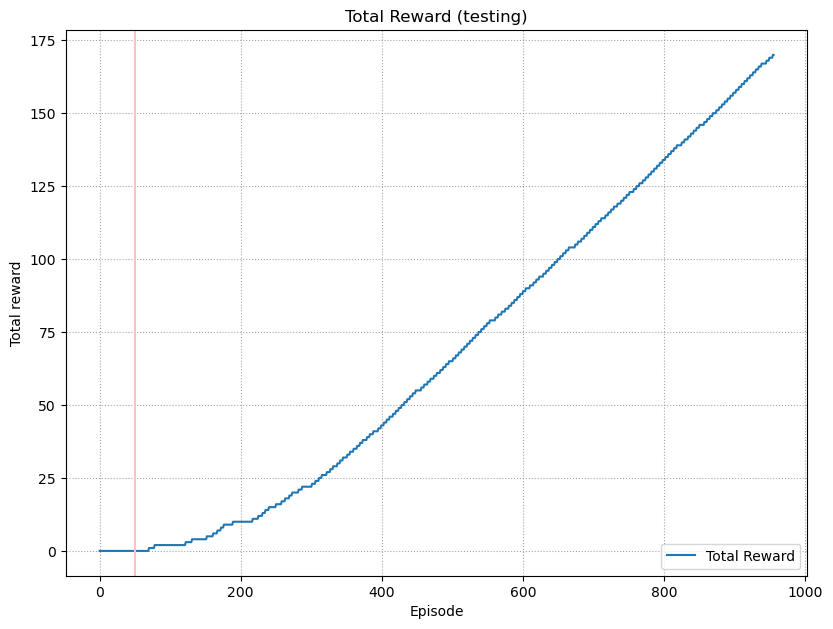

In [19]:
data_plot()

## MX Agent ##

In [8]:
class MXLearningAgent:
    def __init__(self, lr, ie, ed, fe, Beta, Epsilon, MBUS):
        self.MF_agent = MFLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                        )
        self.MB_agent = MBLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                            mbus = MBUS
                        )
        self.beta = Beta
        self.epsilon = Epsilon
    
    def get_action(self, state):
        if random.uniform(0, 1) > self.epsilon:
            if random.uniform(0, 1) < self.beta: # Beta 1 = MB || Beta = 0 = MF
                return np.argmax(self.MB_agent.q_values[state]) # Explore action space
            else:
                return np.argmax(self.MF_agent.q_values[state])  # Exploit learned values  
        else:
            return env.action_space.sample()
            
    def update(self, obs, action, reward, terminated, next_obs):
        self.MF_agent.update(obs, action, reward, terminated, next_obs)
        self.MF_agent.decay_epsilon()
        self.MB_agent.update_transition_model(obs, action, next_obs, reward)
        self.MB_agent.decay_epsilon()
        

### MX test ###

In [9]:
lr = 0.01
n_episodes = 1

ie = 0.4
ed = ie / (env.get_iter() / 2)  # reduce the exploration over time
fe = 0.1

beta = 0.5

agentMX = MXLearningAgent(
    lr = lr,
    ie = ie,
    ed = ed,
    fe = fe,
    Beta = beta,
    Epsilon = 0.1,
    MBUS = 50,
)



addiction_states = []
total_reward = []
healthy_rates = []

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(


In [23]:

pbar = tqdm(total = env.get_iter()+1)
#for episode in tqdm(range(n_episodes)):
obs, info = env.reset()
done = False
addicted = 0
r = 0

a_count = 1
h_count = 1

while not done:
    action = agentMX.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    agentMX.update(obs, action, reward, terminated, next_obs)
    
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1


    done = terminated or truncated
    obs = next_obs
    r += reward
    
    healthy_rates.append(h_count / a_count)
    pbar.update(1)
    
    addiction_states.append(addicted)
    total_reward.append(r)
    
pbar.close()


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 2887.67it/s]


In [24]:
agentMX.MF_agent.q_values
print(h_count)
print(a_count)

50
1


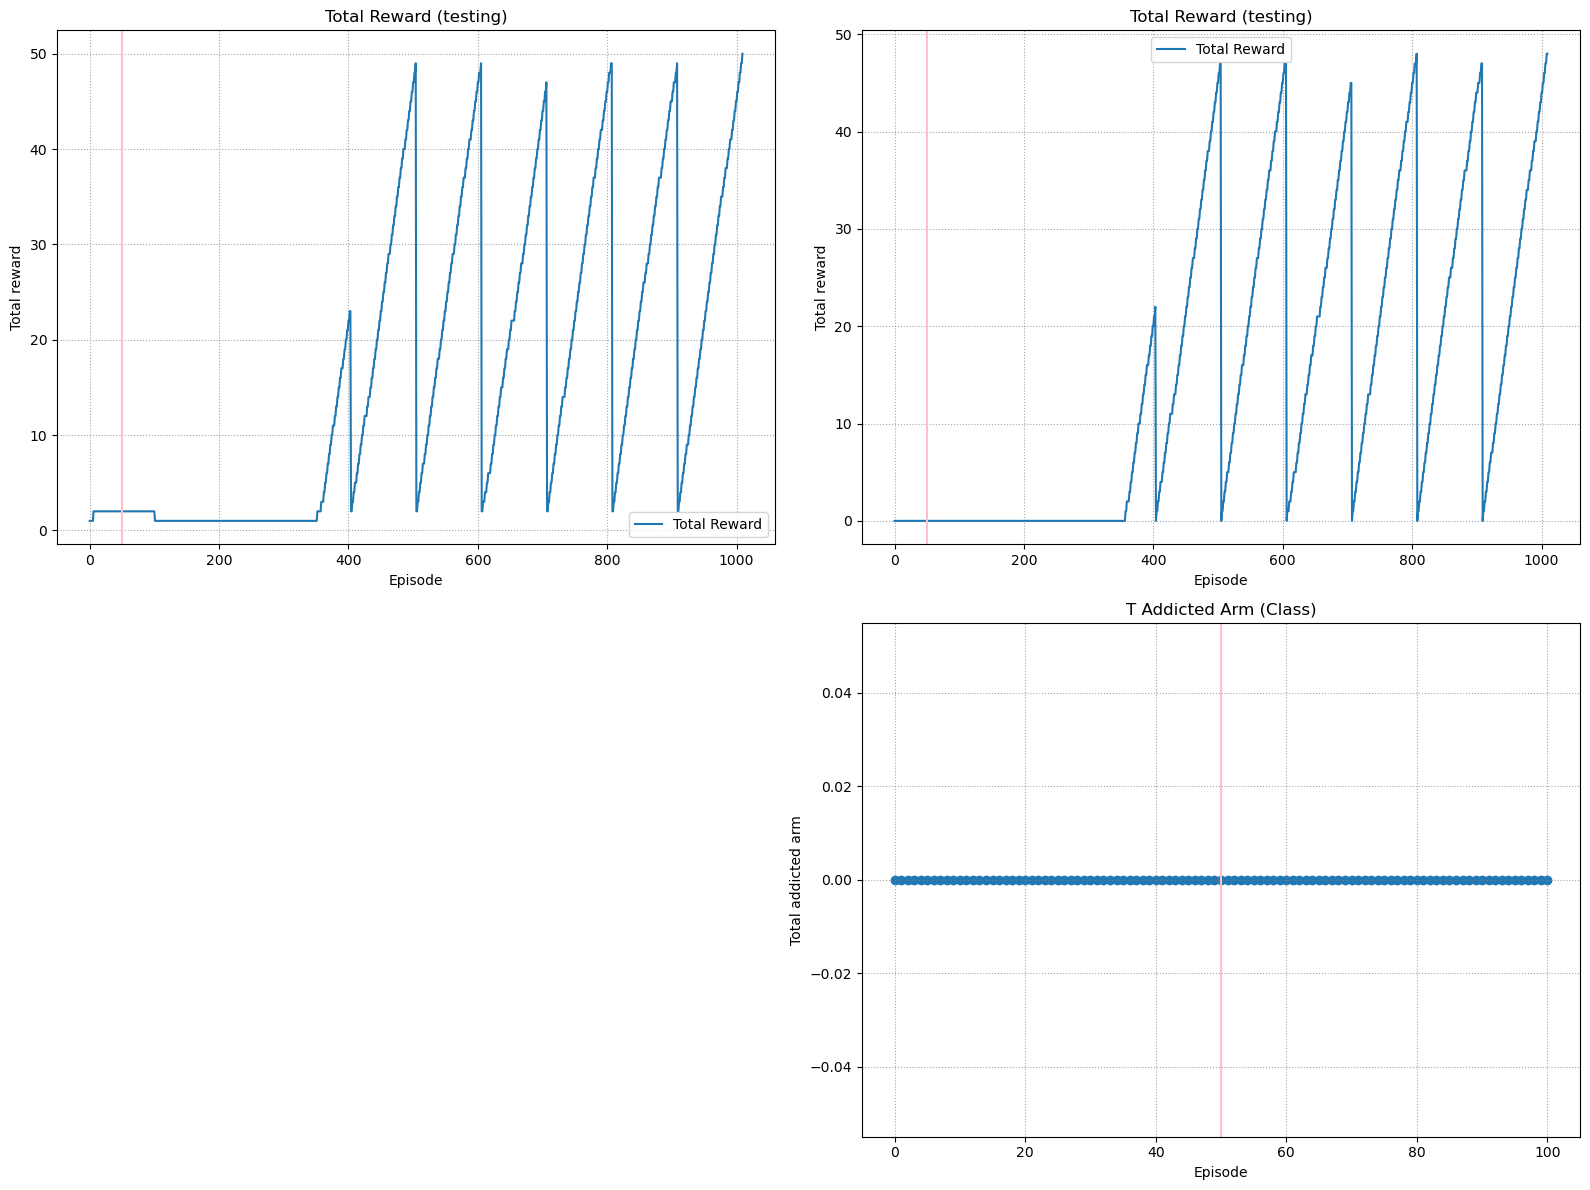

In [25]:
data_plot()

## Multi agent test ##

In [ ]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.05
n_episodes = 1

nagenti = 50

addicted_perc = []
beta = 0.25

pbar_a = tqdm_notebook(total = nagenti, desc='Agent Loop')

ie = 0.4
ed = ie / (env.get_iter() / 2)  # reduce the exploration over time
fe = 0.1

agents = []
for _ in range(nagenti):
    agent = MXLearningAgent(
        lr = lr,
        ie = ie,
        ed = ed,
        fe = fe,
        Beta = beta,
        Epsilon = 0.1,
        MBUS = 1,
    )
    agents.append(agent)

addicted_agents = 0

mean_agents_addicted = []
mean_agents_healthy = []
std_agents_addicted = []
std_agents_healthy = []

tot_addict_h = 0
tot_healthy_h = 0

for agent in agents: 
    
    pbar_a.update(1) 
    obs, info = env.reset()
    
    done = False
    addicted_count = 0
    healthy_count = 0
    # play one episode
    
    # pbar_i.reset()
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)
        #conto stati
        if(obs == 3 and next_obs == 4):
            addicted_count +=  1
        if(obs == 2 and next_obs == 1):
            healthy_count += 1
        
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        # pbar_i.update(1)
     
    if addicted_count > healthy_count:
        addicted_agents += 1

addicted_perc.append((addicted_agents / nagenti) * 100)
# pbar_b.update(1)
    
pbar_a.close()
# pbar_b.close()
# pbar_i.close()

## Beta variabile

In [11]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.05
n_episodes = 1

nagenti = 50

addicted_perc = []
beta_range = [0, 0.25, 0.5, 0.75, 1]


# pbar_b = tqdm(total = 5, position=0,  desc='Beta Loop')
pbar_a = tqdm_notebook(total = nagenti, desc='Agent Loop')
# pbar_i = tqdm(total = env.get_iter()+1, desc='Episode Loop', position = 2)

for B in beta_range:
    pbar_a.reset()
    
    ie = 0.4
    ed = ie / (env.get_iter() / 2)  # reduce the exploration over time
    fe = 0.1
    
    agents = []
    for _ in range(nagenti):
        agent = MXLearningAgent(
            lr = lr,
            ie = ie,
            ed = ed,
            fe = fe,
            Beta = B,
            Epsilon = 0.1,
            MBUS = 1,
        )
        agents.append(agent)
    

    addicted_agents = 0
    
    
    for agent in agents: 
        
        pbar_a.update(1) 
        obs, info = env.reset()
        
        done = False
        addicted_count = 0
        healthy = 0
        # play one episode
        
        # pbar_i.reset()
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            agent.update(obs, action, reward, terminated, next_obs)
            #conto stati
            if(obs == 3 and next_obs == 4):
                addicted_count +=  1
            if(obs == 2 and next_obs == 1):
                healthy += 1
            
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            # pbar_i.update(1)
            
        if addicted_count > healthy:
            addicted_agents += 1
  
    print(f"{B} {addicted_agents}")
    addicted_perc.append((addicted_agents / nagenti) * 100)
    # pbar_b.update(1)
    
pbar_a.close()
# pbar_b.close()
# pbar_i.close()

/tmp/ipykernel_332901/2524536944.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar_a = tqdm_notebook(total = nagenti, desc='Agent Loop')


Agent Loop:   0%|          | 0/50 [00:00<?, ?it/s]

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(


0 0
0.25 0
0.5 2
0.75 1
1 0


/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(


[0.0, 0.0, 4.0, 2.0, 0.0]


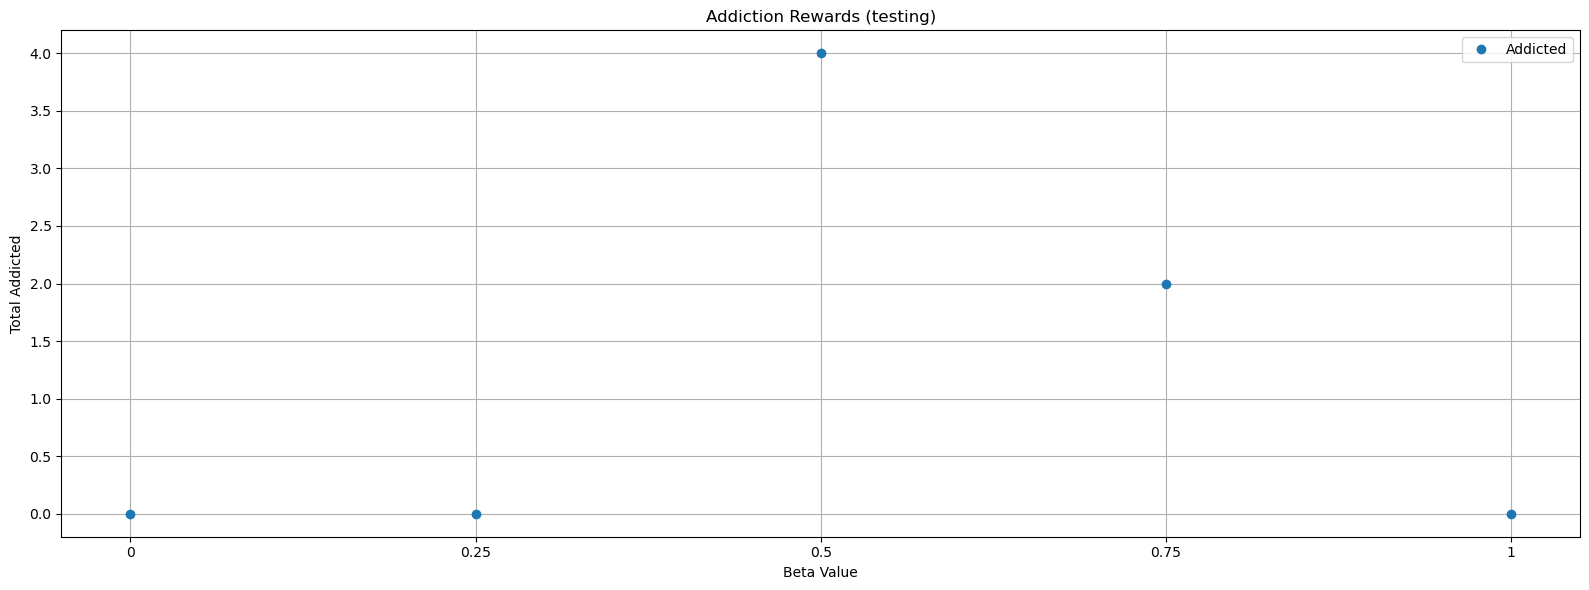

In [12]:
timestamps = np.arange(len(beta_range))

# Print addicted percentage for debugging
print(addicted_perc)

# Plot the graph
plt.figure(figsize=(16, 6))
plt.errorbar(timestamps, addicted_perc, fmt='o', capsize=5, label='Addicted')
plt.xticks(timestamps, beta_range)  # Set beta values as x-axis ticks
plt.title('Addiction Rewards (testing)')
plt.xlabel('Beta Value')
plt.ylabel('Total Addicted')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()